<a href="https://colab.research.google.com/github/alxgrin/kaggle/blob/main/notebooks/c_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Titanic - Machine Learning from Disaster

### 👋🛳️ Ahoy, welcome to Kaggle! You’re in the right place.

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Read on or watch the video below to explore more details. Once you’re ready to start competing, click on the ["Join Competition button](https://www.kaggle.com/account/login?returnUrl=%2Fc%2Ftitanic) to create an account and gain access to the [competition data](https://www.kaggle.com/c/titanic/data). Then check out [Alexis Cook’s Titanic Tutorial](https://www.kaggle.com/alexisbcook/titanic-tutorial) that walks you through step by step how to make your first submission!

[![img](https://storage.googleapis.com/kaggle-media/welcome/video_thumbnail.jpg)](https://www.youtube.com/watch?v=8yZMXCaFshs&feature=youtu.be)

### Data Description

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use [feature engineering ](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)to create new features.

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include **gender_submission.csv**, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Data Dictionary

| **Variable** | **Definition**                             | **Key**                                        |
| :----------- | :----------------------------------------- | :--------------------------------------------- |
| survival     | Survival                                   | 0 = No, 1 = Yes                                |
| pclass       | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex          | Sex                                        |                                                |
| Age          | Age in years                               |                                                |
| sibsp        | # of siblings / spouses aboard the Titanic |                                                |
| parch        | # of parents / children aboard the Titanic |                                                |
| ticket       | Ticket number                              |                                                |
| fare         | Passenger fare                             |                                                |
| cabin        | Cabin number                               |                                                |
| embarked     | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Link: https://www.kaggle.com/c/titanic/overview  

Help: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling, https://www.kaggle.com/ash316/eda-to-prediction-dietanic and https://www.kaggle.com/pavlofesenko/simplest-top-10-titanic-0-80861

In [1]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.4 MB/s 


In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
    Pool,
    cv,
    sum_models,
    to_classifier,
)
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split

In [3]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [4]:
le = preprocessing.LabelEncoder()

## Первичная загрузка данных

In [5]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
DATA_PATH = "/content/drive/MyDrive/kaggle_data/c_titanic"
!ls $DATA_PATH

gender_submission.csv.gz  test.csv.gz  train.csv.gz


In [7]:
gender_submission = pd.read_csv(
    DATA_PATH + "/gender_submission.csv.gz", index_col="PassengerId", compression="gzip"
)
gender_submission

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [8]:
train = pd.read_csv(
    DATA_PATH + "/train.csv.gz", index_col="PassengerId", compression="gzip"
)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [9]:
test = pd.read_csv(
    DATA_PATH + "/test.csv.gz", index_col="PassengerId", compression="gzip"
)
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


На вход были даны 3 дата фрейма, было произведено их обьединение в один для более удобной дальнейшей работы

In [10]:
df = pd.concat([train, test])
df["Survived"].fillna(0, inplace=True)
df["Survived"] = df["Survived"].astype(int)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,0,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [12]:
(df.isna().sum() / len(df)).sort_values(ascending=False)

Cabin       0.774637
Age         0.200917
Embarked    0.001528
Fare        0.000764
Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
dtype: float64

# Обработка полей и генерация новых признаков

## Cabin

In [13]:
df["Cabin"].value_counts(dropna=False)

NaN                1014
C23 C25 C27           6
B57 B59 B63 B66       5
G6                    5
F33                   4
                   ... 
A14                   1
E63                   1
E12                   1
E38                   1
C105                  1
Name: Cabin, Length: 187, dtype: int64

In [14]:
df["Cabin_Class"] = df["Cabin"].fillna("X").str.get(0)
df["Cabin_Class"] = df["Cabin_Class"].astype("category")
df["Cabin_Class"]

PassengerId
1       X
2       C
3       X
4       C
5       X
       ..
1305    X
1306    C
1307    X
1308    X
1309    X
Name: Cabin_Class, Length: 1309, dtype: category
Categories (9, object): ['A', 'B', 'C', 'D', ..., 'F', 'G', 'T', 'X']

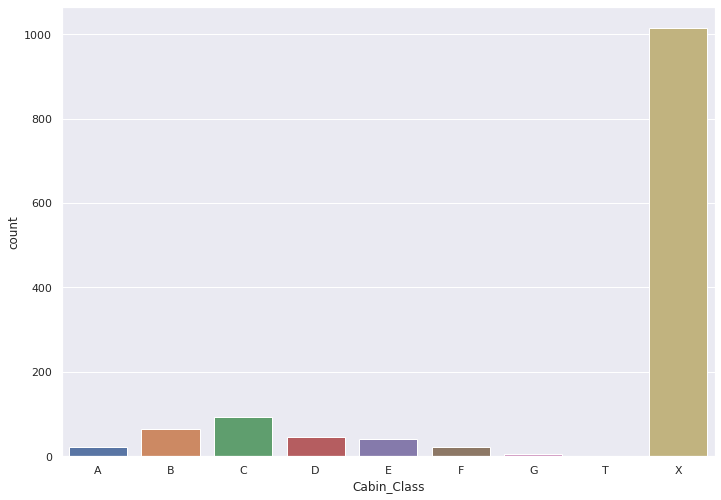

In [15]:
sns.countplot(x=df["Cabin_Class"])

In [16]:
df.drop("Cabin", inplace=True, axis=1)

## Age

In [17]:
df["Age"].value_counts(dropna=False, normalize=True)

NaN     0.200917
24.0    0.035905
22.0    0.032850
21.0    0.031322
30.0    0.030558
          ...   
23.5    0.000764
20.5    0.000764
55.5    0.000764
66.0    0.000764
38.5    0.000764
Name: Age, Length: 99, dtype: float64

In [18]:
df["Empty_Age"] = df["Age"].notnull().astype(int)
df["Empty_Age"]

PassengerId
1       1
2       1
3       1
4       1
5       1
       ..
1305    0
1306    1
1307    1
1308    0
1309    0
Name: Empty_Age, Length: 1309, dtype: int64

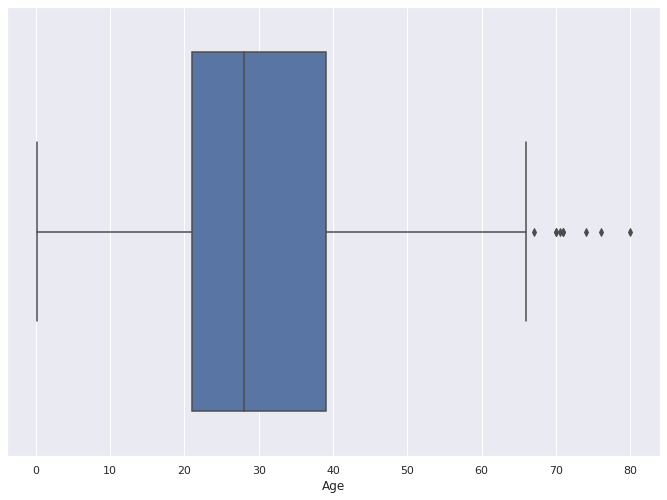

In [19]:
sns.boxplot(x=df["Age"])

## Embarked

In [20]:
df["Embarked"].value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: Embarked, dtype: int64

In [21]:
df["Embarked"].fillna("S", inplace=True)
df["Embarked"] = df["Embarked"].astype("category")

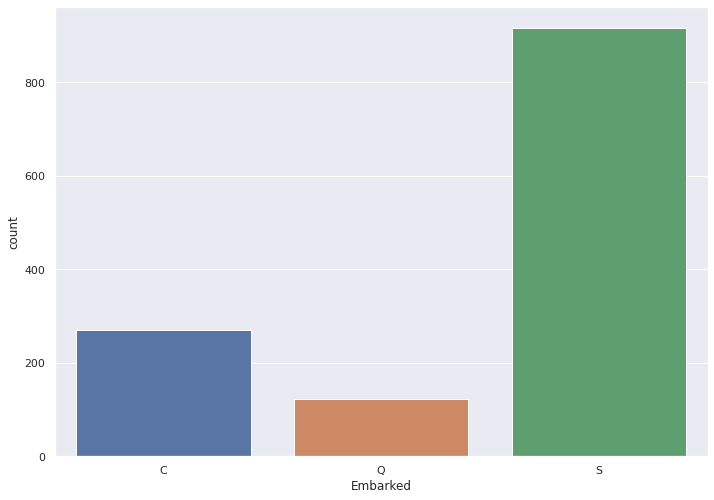

In [22]:
sns.countplot(x=df["Embarked"])

## Fare

In [23]:
df["Fare"].value_counts(dropna=False, normalize=True)

8.0500     0.045837
13.0000    0.045073
7.7500     0.042017
26.0000    0.038197
7.8958     0.037433
             ...   
26.2833    0.000764
14.0000    0.000764
15.0000    0.000764
6.2375     0.000764
7.7208     0.000764
Name: Fare, Length: 282, dtype: float64

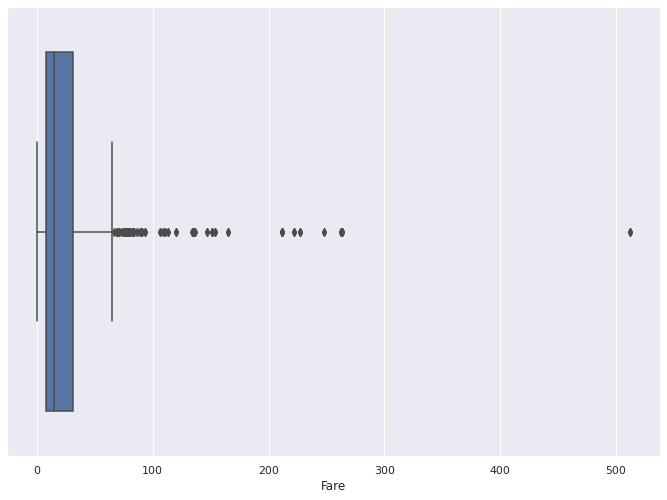

In [24]:
sns.boxplot(x=df["Fare"])

In [25]:
df["Fare_Class"] = pd.qcut(df["Fare"], 4)
df["Fare_Class"].value_counts()

(-0.001, 7.896]      337
(14.454, 31.275]     328
(31.275, 512.329]    323
(7.896, 14.454]      320
Name: Fare_Class, dtype: int64

In [26]:
df["Fare_Class"] = le.fit_transform(df["Fare_Class"])
df["Fare_Class"]

PassengerId
1       0
2       3
3       1
4       3
5       1
       ..
1305    1
1306    3
1307    0
1308    1
1309    2
Name: Fare_Class, Length: 1309, dtype: int64

In [27]:
df.drop("Fare", inplace=True, axis=1)

## Ticket

In [28]:
df["Ticket"].value_counts()

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: Ticket, Length: 929, dtype: int64

In [29]:
df["Ticket_Class"] = (
    df["Ticket"].str.split(" ").map(lambda x: "X" if x[0].isdigit() else x[0])
)
df["Ticket_Class"].value_counts()

X             957
PC             92
C.A.           46
SOTON/O.Q.     16
STON/O         14
W./C.          14
A/5            12
CA.            12
SC/PARIS       11
CA             10
A/5.           10
F.C.C.          9
SOTON/OQ        8
C               8
S.O.C.          7
S.O./P.P.       7
STON/O2.        7
A/4             6
SC/Paris        5
SC/AH           5
LINE            4
PP              4
SOTON/O2        3
S.C./PARIS      3
F.C.            3
A.5.            3
A/4.            3
A./5.           3
W.E.P.          2
P/PP            2
SC              2
WE/P            2
STON/OQ.        1
AQ/4            1
SC/A.3          1
C.A./SOTON      1
A.              1
LP              1
SC/A4           1
Fa              1
S.W./PP         1
A/S             1
SCO/W           1
SW/PP           1
W/C             1
S.O.P.          1
A4.             1
SO/C            1
S.P.            1
S.C./A.4.       1
AQ/3.           1
Name: Ticket_Class, dtype: int64

In [30]:
df["Ticket_Class"] = df["Ticket_Class"].map(
    lambda x: "".join(ch for ch in x if ch.isalnum())
)
df["Ticket_Class"] = le.fit_transform(df["Ticket_Class"])

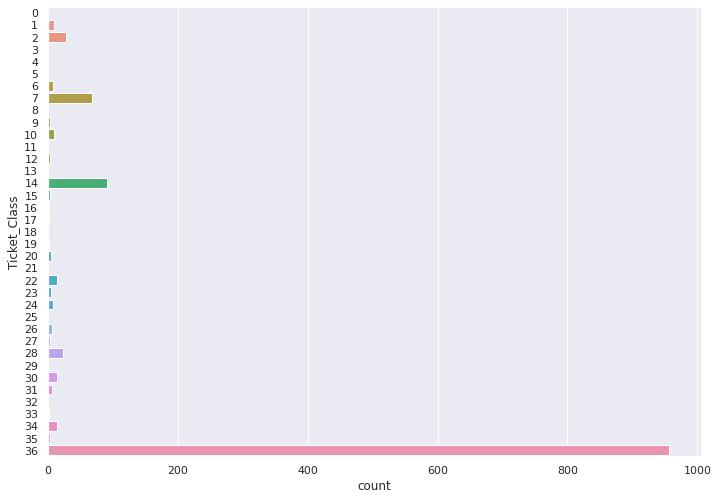

In [31]:
sns.countplot(y=df["Ticket_Class"])

In [32]:
df.drop("Ticket", inplace=True, axis=1)

## Parch/SibSp

### Количество родителей/детей на борту (Parch)

In [33]:
df["Parch"].value_counts(dropna=False)

0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: Parch, dtype: int64

### Братьев и сестер/супругов на борту (SibSp)

In [34]:
df["SibSp"].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [35]:
df["Family_Size"] = 1 + df["Parch"] + df["SibSp"]

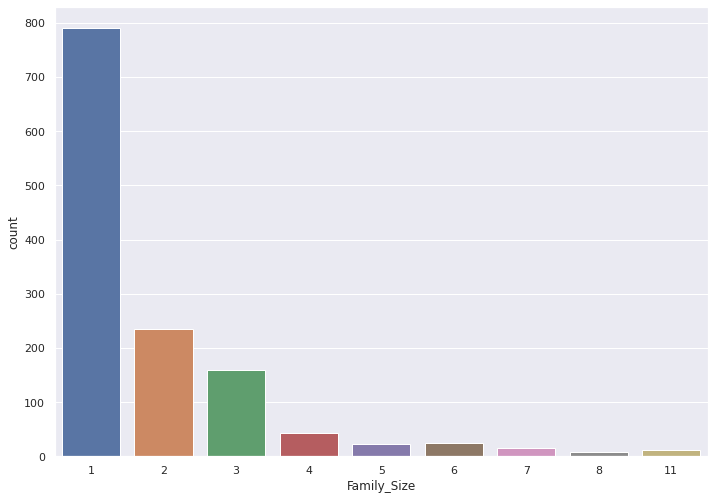

In [36]:
sns.countplot(x=df["Family_Size"])

In [37]:
df["Is_Single"] = (df["Family_Size"] == 1).astype(int)

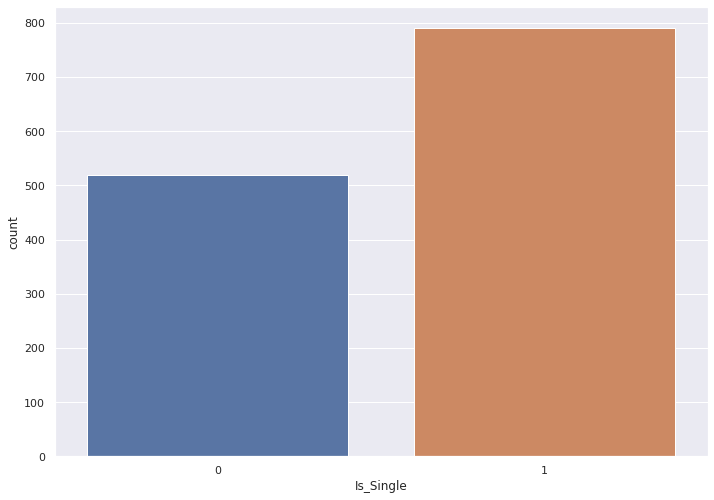

In [38]:
sns.countplot(x=df["Is_Single"])

## Sex

In [39]:
df["Sex"].value_counts(dropna=False)

male      843
female    466
Name: Sex, dtype: int64

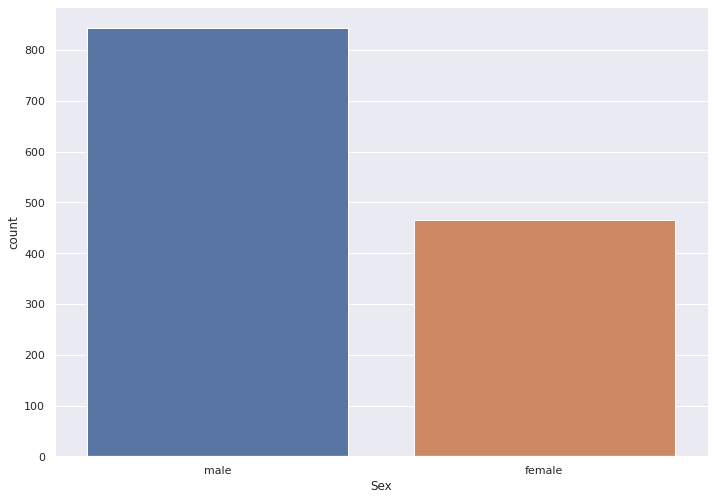

In [40]:
sns.countplot(x=df["Sex"])

In [41]:
df["Sex"] = df["Sex"].replace({"female": 1, "male": 0})

## Name

In [42]:
df["Name"].value_counts(dropna=False)

Connolly, Miss. Kate                                   2
Kelly, Mr. James                                       2
Braund, Mr. Owen Harris                                1
Johnson, Master. Harold Theodor                        1
Gustafsson, Mr. Alfred Ossian                          1
                                                      ..
Carter, Miss. Lucile Polk                              1
Silvey, Mr. William Baird                              1
Kallio, Mr. Nikolai Erland                             1
Louch, Mrs. Charles Alexander (Alice Adelaide Slow)    1
Peter, Master. Michael J                               1
Name: Name, Length: 1307, dtype: int64

In [43]:
df["Prefix"] = df["Name"].str.split(",").str[1].str.split(".").str[0]
df["Prefix"] = df["Prefix"].astype("category")
df["Prefix"].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Ms                2
 Major             2
 Mlle              2
 Sir               1
 Capt              1
 Mme               1
 Lady              1
 Jonkheer          1
 Dona              1
 Don               1
 the Countess      1
Name: Prefix, dtype: int64

In [44]:
df["Is_Master"] = (df["Prefix"] == "Master").astype(int)

In [45]:
df.drop("Name", inplace=True, axis=1)

## Pclass

In [46]:
df["Pclass"].value_counts(dropna=False)

3    709
1    323
2    277
Name: Pclass, dtype: int64

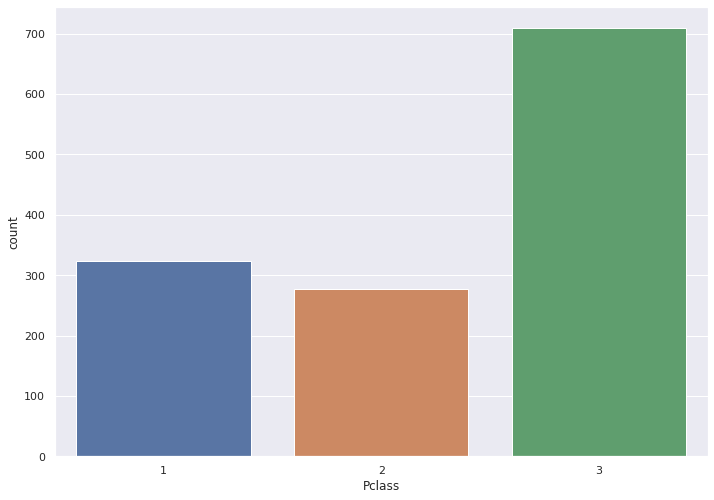

In [47]:
sns.countplot(x=df["Pclass"])

# Заполнение пропусков для колонки `Age` (возраст)

In [48]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Cabin_Class,Empty_Age,Fare_Class,Ticket_Class,Family_Size,Is_Single,Prefix,Is_Master
PassengerId,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,S,X,1,0,2,2,0,Mr,0
2,1,1,1,38.0,1,0,C,C,1,3,14,2,0,Mrs,0
3,1,3,1,26.0,0,0,S,X,1,1,31,1,1,Miss,0
4,1,1,1,35.0,1,0,S,C,1,3,36,2,0,Mrs,0
5,0,3,0,35.0,0,0,S,X,1,1,36,1,1,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,3,0,NaN,0,0,S,X,0,1,2,1,1,Mr,0
1306,0,1,1,39.0,0,0,C,C,1,3,14,1,1,Dona,0
1307,0,3,0,38.5,0,0,S,X,1,0,28,1,1,Mr,0


In [49]:
train_age_df = df[~df["Age"].isnull()]
test_age_df = df[df["Age"].isnull()]

train_age_df.shape, test_age_df.shape

((1046, 15), (263, 15))

In [50]:
y_age = train_age_df["Age"]
X_age = train_age_df.drop("Age", axis=1)

X_age.shape, y_age.shape

((1046, 14), (1046,))

In [51]:
cat_age_features = list(set(X_age.columns) - set(X_age._get_numeric_data().columns))
cat_age_features

['Cabin_Class', 'Embarked', 'Prefix']

In [52]:
X_age_train, X_age_val, y_age_train, y_age_val = train_test_split(
    X_age, y_age, train_size=0.8, random_state=42
)
X_age_train.shape, X_age_val.shape, y_age_train.shape, y_age_val.shape

((836, 14), (210, 14), (836,), (210,))

In [53]:
model = CatBoostRegressor(random_seed=42)

In [54]:
model.fit(
    Pool(X_age_train, y_age_train, cat_features=cat_age_features),
    eval_set=Pool(X_age_val, y_age_val, cat_features=cat_age_features),
    verbose=False,
)

In [55]:
model.best_score_

{'learn': {'RMSE': 7.252332969441223},
 'validation': {'RMSE': 9.828117114943376}}

In [56]:
age_preds = model.predict(test_age_df.drop("Age", axis=1))
age_preds

array([30.96836709, 31.55043157, 30.32489994, 28.67607179, 22.07758126,
       29.0973547 , 41.44219496, 22.07758126, 27.26161898, 28.67607179,
       29.39214009, 30.32636479, 22.07758126, 26.83530479, 39.73071557,
       41.85940927,  4.53209437, 29.0973547 , 29.18845075, 22.07758126,
       28.95555663, 29.18845075, 29.0973547 , 28.12835077, 19.30057096,
       30.06611726, 31.0460599 ,  8.02492664, 30.35894265, 29.87939827,
       29.18845075,  7.87971107, 42.47272584, 42.34284057,  5.18325793,
        9.74994793, 32.1465231 , 43.23655031, 30.24299835, 31.0460599 ,
       22.07758126, 25.59799052, 29.64190377, 29.0973547 ,  8.78858132,
       23.23610704, 19.79185833, 19.30057096, 29.0973547 , 42.73723884,
       31.0460599 , 23.41378031, 42.42081399, 22.07758126, 32.43747408,
       43.86409882, 41.85940927, 40.19720963, 22.07758126, 27.27691004,
       26.93008565, 30.06611726, 32.09975878, 25.59799052, 15.30038533,
       42.13364996, 29.0973547 , 30.79141179, 41.94441243, 28.67

In [57]:
age_df = pd.DataFrame({"PassengerId": test_age_df.index, "Age": age_preds}).set_index(
    "PassengerId"
)
age_df

,Age
PassengerId,
6,30.968367
18,31.550432
20,30.324900
27,28.676072
29,22.077581
...,...
1300,23.413780
1302,23.413780
1305,30.066117


In [58]:
df.update(age_df)
df["Age"] = df["Age"].astype(int)

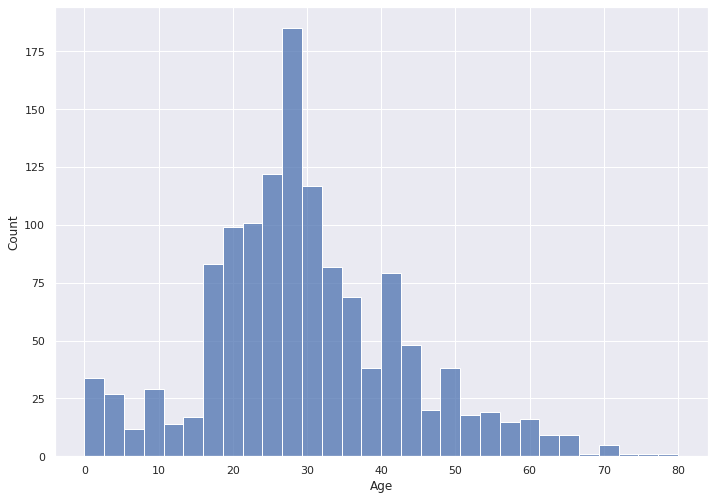

In [59]:
sns.histplot(x=df["Age"])

## Выделение признаков на основе возраста

In [60]:
df["Age_Girl"] = ((df["Age"] <= 16) & (df["Sex"] == 1)).astype(int)
df["Age_Boy"] = ((df["Age"] <= 16) & (df["Sex"] == 0)).astype(int)

# Разбивка данных для обучения

In [61]:
best_columns = [
    "Prefix",
    "Pclass",
    "Fare_Class",
    "Sex",
    "Embarked",
    "Cabin_Class",
    "Age",
    "SibSp",
]

In [62]:
y = df["Survived"]
X = df.drop("Survived", axis=1)
X

,Pclass,Sex,Age,SibSp,Parch,Embarked,Cabin_Class,Empty_Age,Fare_Class,Ticket_Class,Family_Size,Is_Single,Prefix,Is_Master,Age_Girl,Age_Boy
PassengerId,,,,,,,,,,,,,,,,
1,3,0,22,1,0,S,X,1,0,2,2,0,Mr,0,0,0
2,1,1,38,1,0,C,C,1,3,14,2,0,Mrs,0,0,0
3,3,1,26,0,0,S,X,1,1,31,1,1,Miss,0,0,0
4,1,1,35,1,0,S,C,1,3,36,2,0,Mrs,0,0,0
5,3,0,35,0,0,S,X,1,1,36,1,1,Mr,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,0,30,0,0,S,X,0,1,2,1,1,Mr,0,0,0
1306,1,1,39,0,0,C,C,1,3,14,1,1,Dona,0,0,0
1307,3,0,38,0,0,S,X,1,0,28,1,1,Mr,0,0,0


In [63]:
X_test = X[X.index.isin(test.index)]

X = X[X.index.isin(train.index)]
y = y[y.index.isin(train.index)].astype(int)

X.shape, y.shape, X_test.shape

((891, 16), (891,), (418, 16))

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        891 non-null    int64   
 1   Sex           891 non-null    int64   
 2   Age           891 non-null    int64   
 3   SibSp         891 non-null    int64   
 4   Parch         891 non-null    int64   
 5   Embarked      891 non-null    category
 6   Cabin_Class   891 non-null    category
 7   Empty_Age     891 non-null    int64   
 8   Fare_Class    891 non-null    int64   
 9   Ticket_Class  891 non-null    int64   
 10  Family_Size   891 non-null    int64   
 11  Is_Single     891 non-null    int64   
 12  Prefix        891 non-null    category
 13  Is_Master     891 non-null    int64   
 14  Age_Girl      891 non-null    int64   
 15  Age_Boy       891 non-null    int64   
dtypes: category(3), int64(13)
memory usage: 101.2 KB


In [65]:
cat_features = list(set(X.columns) - set(X._get_numeric_data().columns))
cat_features

['Cabin_Class', 'Embarked', 'Prefix']

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((801, 16), (90, 16), (801,), (90,))

## Разбивка на фолды и сборка ансамбля

In [67]:
ensemble = []

In [68]:
for X_fold_train in np.array_split(X_train, 5):
    y_fold_train = y_train[y_train.index.isin(X_fold_train.index)]

    model = CatBoostClassifier(eval_metric="Accuracy", random_seed=42)

    model.fit(
        Pool(X_fold_train, y_fold_train, cat_features=cat_features),
        eval_set=Pool(X_val, y_val, cat_features=cat_features),
        verbose=False,
    )

    ensemble.append(model)
    print(model.best_score_)

{'learn': {'Accuracy': 0.9937888198757764, 'Logloss': 0.052460921998818806}, 'validation': {'Accuracy': 0.8444444444444444, 'Logloss': 0.3464432559549384}}
{'learn': {'Accuracy': 1.0, 'Logloss': 0.0734895323932229}, 'validation': {'Accuracy': 0.8555555555555555, 'Logloss': 0.4246102447564591}}
{'learn': {'Accuracy': 1.0, 'Logloss': 0.043098694058261125}, 'validation': {'Accuracy': 0.8444444444444444, 'Logloss': 0.4081128258929079}}
{'learn': {'Accuracy': 1.0, 'Logloss': 0.05731317842556264}, 'validation': {'Accuracy': 0.8111111111111111, 'Logloss': 0.4527647467947169}}
{'learn': {'Accuracy': 0.99375, 'Logloss': 0.055446890362899515}, 'validation': {'Accuracy': 0.8222222222222222, 'Logloss': 0.43316878824697774}}


In [69]:
ensemble

In [70]:
best_model = ensemble[0]

In [71]:
# Выделение лучших столбцов для повторного прогона
column_scores = pd.DataFrame(
    {"Column": X.columns, "Score": best_model.get_feature_importance()}
).sort_values("Score", ascending=False)
column_scores

,Column,Score
12,Prefix,35.916843
0,Pclass,14.744268
8,Fare_Class,12.918359
1,Sex,8.634553
5,Embarked,6.426539
6,Cabin_Class,5.903624
2,Age,3.891472
3,SibSp,3.498835
9,Ticket_Class,3.484841
10,Family_Size,2.182283


In [72]:
best_columns = column_scores[column_scores["Score"] >= column_scores["Score"].median()][
    "Column"
].to_list()
best_columns

['Prefix',
 'Pclass',
 'Fare_Class',
 'Sex',
 'Embarked',
 'Cabin_Class',
 'Age',
 'SibSp']

# Предсказание результатов

In [73]:
y_preds = pd.DataFrame()

In [74]:
for idx, model in enumerate(ensemble):
    y_preds["Model_%d" % idx] = model.predict(X_test)

In [75]:
y_preds.mean(axis=1).astype(int)

0      0
1      0
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Length: 418, dtype: int64

In [76]:
X_test.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [77]:
submission = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": y_preds.mean(axis=1).astype(int)}
).set_index("PassengerId")
submission

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


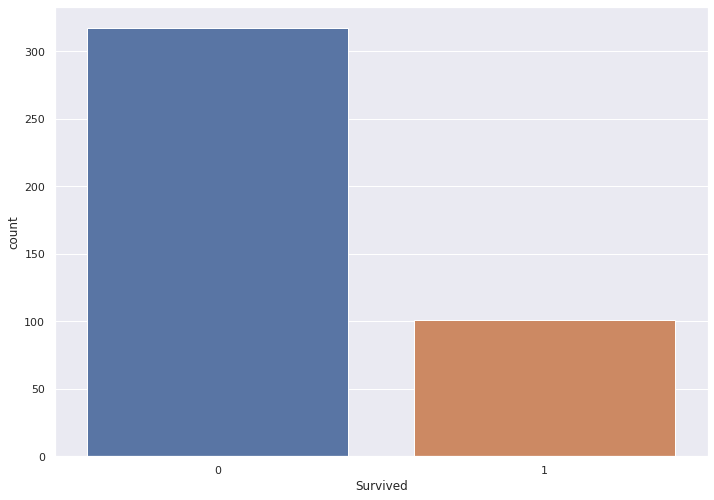

In [78]:
sns.countplot(x=submission["Survived"])

In [79]:
submission.to_csv("submission.csv")